## Needed imports

We will only need numpy and matplotlib as external libraries

In [1]:
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Problem classes

In [2]:
class Action(Enum):
    
    """
    Set of actions we can take in the game
    """
    
    move_right = 'move_right'
    move_left = 'move_left'
    move_up= 'move_up'
    move_down = 'move_down'
    
    @classmethod
    def to_int(self, action):
        return list(Action).index(Action(action))
    
    @classmethod
    def from_int(self, index):
        return list(Action)[index]
    
    @classmethod
    def movement(self, action):
        return {
            Action.move_right: [0, 1],
            Action.move_left: [0, -1],
            Action.move_up: [-1, 0],
            Action.move_down: [1, 0]
        }[Action(action)]

In [653]:
class Environment(object):
    
    """
    Sensoring field we react to. The only information we have from it is:

        - Initial state
        - Goal state
        - Obstacle information
        - Actions we can perform on the environment
        - Next state and reward of an action
    
    In a real problem, the environment would only expose the current state,
    the possible actions to perform and the reward to our actions.
    """
    
    def __init__(self, grid_size, max_obstacles):
        self._grid_size = grid_size
        self._state_space_size = self._grid_size * self._grid_size
        self._actions_per_state = []
        self._define_state_actions()
        self.reset()
        self._num_obstacles = np.random.randint(1, max_obstacles)
        self._obstacle_states = self._sample_obstacles()
        
    @property
    def action_space(self) -> int: return len(Action)
        
    @property
    def start_state(self) -> int: return self._start_state
    
    @property
    def start_state_point(self) -> []: 
        return self._state_to_point(self.start_state)
    
    @property
    def goal_state(self) -> int: return self._goal_state
    
    @property
    def goal_state_point(self) -> []:
        return self._state_to_point(self.goal_state)
    
    @property
    def current_state(self) -> int: return self._current_state
    
    @property
    def current_state_point(self) -> []:
        return self._state_to_point(self.current_state)
    
    @property
    def grid_size(self) -> int: return self._grid_size
    
    @property
    def state_space_size(self) -> int: return self._state_space_size
    
    @property
    def actions_per_state(self) -> []:
        return self._actions_per_state

    @property
    def health(self) -> float: return self._health
    
    @property
    def obstacle_states(self) -> []: return self._obstacle_states
    
    @property
    def obstacle_points(self) -> []:
        return [self._state_to_point(x) for x in self.obstacle_states]
    
    def _sample_obstacles(self) -> []:
        
        def _sample_obstacle() -> int:
            return np.random.randint(self._state_space_size)
        
        obstacles = []
        for _ in range(self._num_obstacles):
            # Make sure obstacles are not placed in start or goal states
            sampled = _sample_obstacle()
            while sampled in [self.goal_state, self.start_state]:
                sampled = _sample_obstacle()
            obstacles.append(sampled)

        return obstacles 

    
    def get_current_allowed_actions(self) -> []:
        return self._actions_per_state[self.current_state]
    
    def reset(self):
        self._start_state = 0
        self._current_state = self._start_state
        self._goal_state = self._state_space_size - 1
        self._health = 100
    
    def move(self, action: Action) -> []:
        """
        Returns state after the action and the immediate reward received
        """
        if action not in self.actions_per_state[self.current_state]:
            raise ValueError(
                "Invalid movement {} for state {}".format(action, self.current_state)
            )

        # Add movement to position
        current_point  = self.current_state_point
        lapsed = Action.movement(action)
        next_position = [x + y for x, y in zip(current_point, lapsed)]
        
        # If obstacle in next position, we damage the agent
        if self.current_state in self.obstacle_states:
            self._health -= 40
        
        # Update current point
        self._current_state = self._point_to_state(next_position)
        return (
            self._current_state,
            self._reward(self._current_state),
            self.current_state == self.goal_state,
            self.health <= 0
        )

    def _reward(self, state: int) -> float:
        if self.goal_state == state: return 1.0
        elif state in self.obstacle_states: return -1.0
        else: return 0.0
    
    def _define_state_actions(self):
        """
        Stores the list of actions that are allowed per state
        """
        state_actions = []
        for i in range(self.state_space_size):
            row, col = self._state_to_point(i)
            actions = []

            if (row > 0): actions.append(Action.move_up)
            if (row < self._grid_size - 1): actions.append(Action.move_down)
            if (col > 0): actions.append(Action.move_left)
            if (col < self._grid_size - 1): actions.append(Action.move_right)

            state_actions.append(actions)
        self._actions_per_state = state_actions
    
    
    def _state_to_point(self, state: int) -> []:
        return [int(state / self.grid_size), state % self.grid_size]
    
    def _point_to_state(self, position: []) -> int:
        return position[0] * self.grid_size + position[1] 
    
    def display(self, **params):
        grid = np.ones((self.grid_size, self.grid_size))
        
        goal_y, goal_x = self.goal_state_point
        grid[goal_y, goal_x] = 0.30
        
        for obstacle_y, obstacle_x in self.obstacle_points:
            grid[obstacle_y, obstacle_x] = 0.10

        current_y, current_x = self.current_state_point
        grid[current_y, current_x] = 0.20
        
        plt.figure(**params)
        plt.imshow(grid, aspect='auto', cmap=plt.get_cmap("Pastel1"))

In [193]:
class QTable(object):
    
    """
    It represents the Q function, which maps a state and an action
    into an expectation of success. 
    
    This function is updated though learning and provides an estimator
    of the underlying reward function on the long term.
    
    For more information: https://en.wikipedia.org/wiki/Q-learning
    """
    
    def __init__(self,
                 state_space_size,
                 action_space,
                 learning_rate=0.2,
                 discount_factor=0.5):
        self._qtable = np.zeros((state_space_size, action_space))
        self._lr = learning_rate
        self._gamma = discount_factor
    
    def handle_impossible_actions(self, actions_per_state):
        # Set impossible values to minus infinite
        for state in range(len(actions_per_state)):
            impossible_actions = [
                Action.to_int(action)
                for action in list(Action)
                if action not in actions_per_state[state]
            ]
            self._qtable[state, impossible_actions] = np.float("-inf")

    def _get_new_qvalue(self,
                        state_t: int,
                        action_t: Action,
                        state_t1: int,
                        reward: float) -> float:
        action_t_idx = Action.to_int(action_t)
        return (1 - self._lr) * self._qtable[state_t, action_t_idx] + \
            self._lr * (reward + self._gamma * np.max(self._qtable[state_t1, ...]))
    
    def get_qvalues(self, state: int) -> []:
        return self._qtable[state, ...]
    
    def update(self,
               state_t: int,
               action_t:
               Action,
               state_t1: int, reward: float):
        action_t_idx = Action.to_int(action_t)
        self._qtable[state_t, action_t_idx] = \
            self._get_new_qvalue(state_t, action_t, state_t1, reward)

    def display(self, **params):
        fig = plt.figure(**params)
        ax = plt.gca()
        # Show ticks for more elegant visualization
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        # Name axis
        plt.xlabel("Action")
        plt.ylabel("State")
        plt.imshow(self._qtable, aspect='auto')
        plt.colorbar()

In [194]:
class Agent(object):
    
    """
    Agent that is playing with the environment
    
    The agent has some randomness to empower exploration, so we
    can find new potentially good strategies.
    """
    
    def __init__(self, random_probability=0.20):
        """
        Initializes an agent that must act according to the environment
        and the quality of the reward expectations given states and actions
        Args:
            error_probability: probability of taking a random action
        """
        self._random_probability = random_probability
        
    def select_action(self, env: Environment, qvalues: []) -> Action:
        """
        Selects the next action to be taken
        Args:
            env: game environment
            qvalues: quality expectation of the actions to take
        """
        allowed_actions = env.get_current_allowed_actions()
        # Draw random number to see if we take a random action
        if np.random.rand() < self._random_probability:
            return allowed_actions[np.random.randint(len(allowed_actions))]
        else:
            return Action.from_int(np.argmax(qvalues))

### Define 'play game' function 

In [432]:
def play_single_game(env,
                     agent,
                     qtable,
                     max_steps=10000,
                     display=False,
                     game_over_value=-1,
                     evaluation=False):

    env.reset()
    win = False
    
    for step in range(1, max_steps+1):
             
        # Get current state
        prev_state = env.current_state
            
        # Compute next movement
        action = agent.select_action(
            env, qtable.get_qvalues(env.current_state)
        )
        
        # Update current state
        current_state, reward, has_won, game_over = env.move(action)
        
        if evaluation is False:
            # Update qtable with movement chosen if not in evaluation mode
            qtable.update(prev_state, action, current_state, reward)
        
        if display: 
            env.display()
        
        if has_won:
            win = True
            break
        
        if game_over:
            break

    if win:
        return step
    else:
        return game_over_value

    
def plot_step_evolution(hist, **params):
    x_data = [i for i, x in enumerate(hist) if x > 0]
    y_data = [x for i, x in enumerate(hist) if x > 0]
    plt.figure(**params)
    plt.plot(x_data, y_data)
    plt.ylabel("Steps to finish")
    plt.xlabel("Time (rounds)")

### Game initialization: simple scenario

In [560]:
env = Environment(5, 5)
agent = Agent(random_probability=0.10)
qtable = QTable(
    state_space_size=env.state_space_size,
    action_space=env.action_space,
    learning_rate=0.50,
    discount_factor=0.20
)
qtable.handle_impossible_actions(env.actions_per_state)

Let's visualize the game environment.

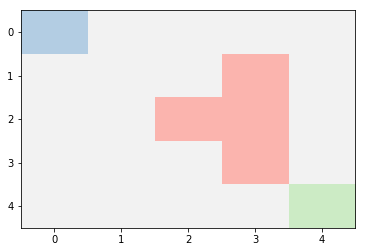

In [561]:
env.display(figsize=(6, 4))

The first matrix represents the "playground". The blue point is the current state and the grren
point is the goal state. The obstacles are marked as red. This is a very simple scenario.

Now let's take a look at what our QTable looks like:

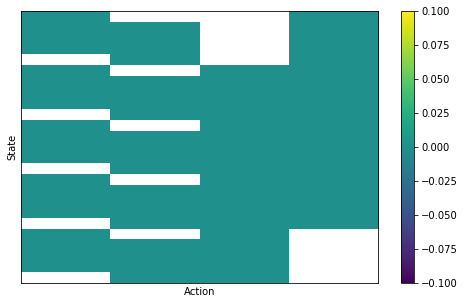

In [562]:
qtable.display(figsize=(8, 5))

The blank spaces in the table are combinations of states and actions which are not possible. At the beginning, expectation of any action at any given state is 0. Let's play some rounds.

In [563]:
winning_hist = []
games_to_play = 1000
for game in range(games_to_play):
    steps_to_win = play_single_game(env, agent, qtable, max_steps=5000)
    winning_hist.append(steps_to_win)

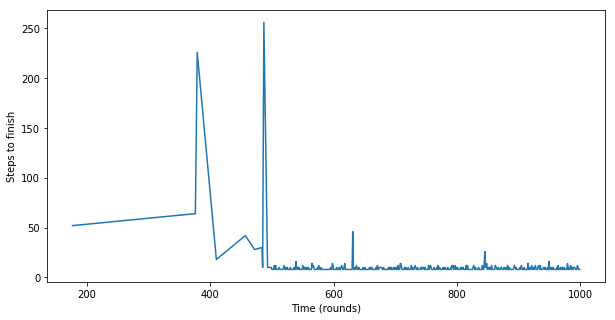

In [564]:
plot_step_evolution(winning_hist, figsize=(10, 5))

If we look at the evolution of the required steps to win through time, we can observe how the agent converges after ~500 games.
We are using random environment: other set ups may have cause a different evolution of the agent through the environment. There are some values in the plot which may be missing: when the agent has not been able to find the goal within the maximum number of steps or when the health of the agent (damaged each time it founds an obstacle) decreased below 0.

After convergence, oscillations are due to the randomness introduced in the agent.

Now let's take a look at the QTable after the experiment:

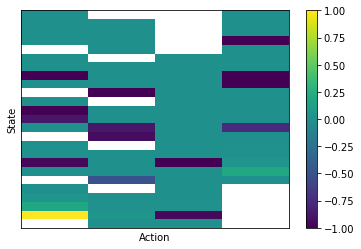

In [565]:
qtable.display()

We see how the goal point has a high reward and that states close to the point have also increased their score.

Let's have a look at the progression of an agent after it has converged:

8

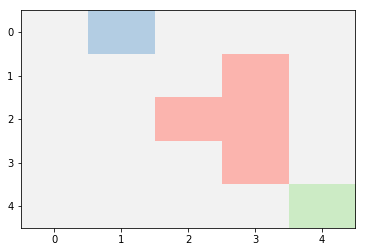

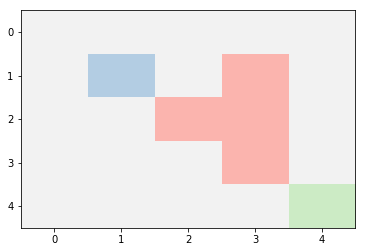

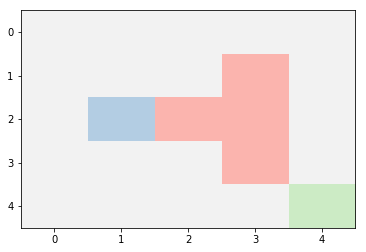

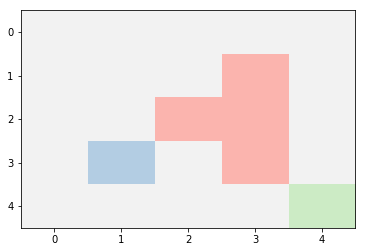

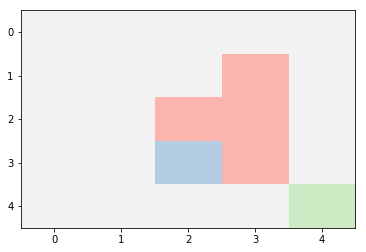

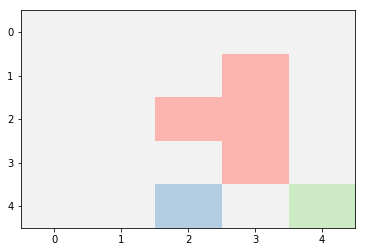

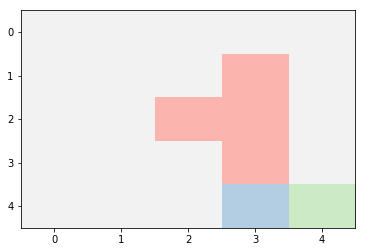

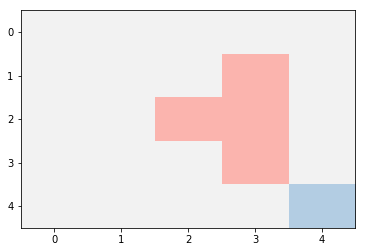

In [566]:
play_single_game(env, agent, qtable, display=True, evaluation=True)

### Larger environments

It is clear that the larger the environment and/or the number of obstacles, the longer the agent will need to play to succeed. However, the hogher the probability of taking a random action, the higher chance to fall into obstacles by mistake.

Let's make the agent play again in a more complex environment.

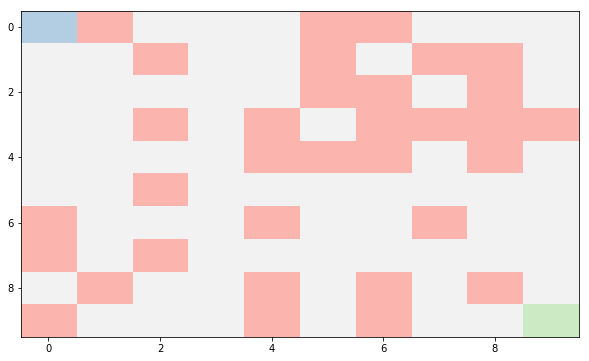

In [694]:
env = Environment(10, 100)
agent = Agent(random_probability=0.10)
qtable = QTable(
    state_space_size=env.state_space_size,
    action_space=env.action_space,
    learning_rate=0.50,
    discount_factor=0.50
)
qtable.handle_impossible_actions(env.actions_per_state)
env.display(figsize=(10, 6))

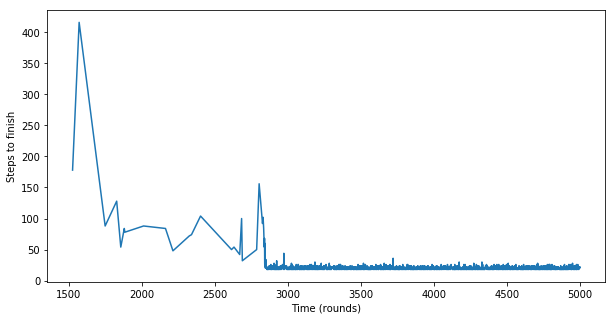

In [695]:
winning_hist = []
games_to_play = 5000
for game in range(games_to_play):
    steps_to_win = play_single_game(env, agent, qtable, max_steps=10000)
    winning_hist.append(steps_to_win)

plot_step_evolution(winning_hist, figsize=(10, 5))

18

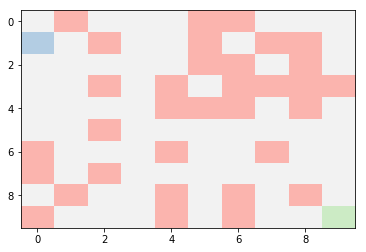

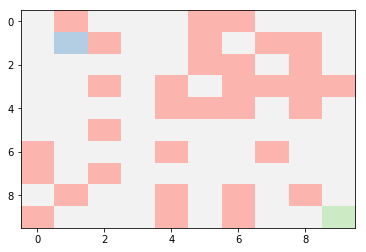

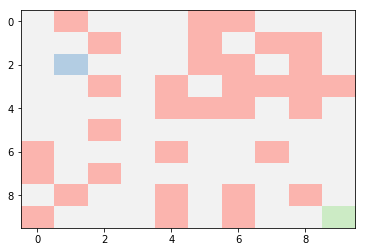

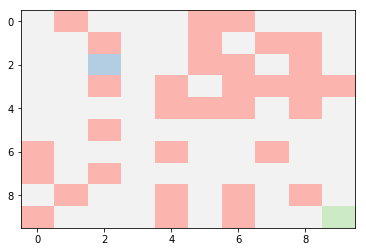

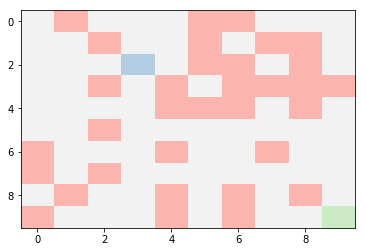

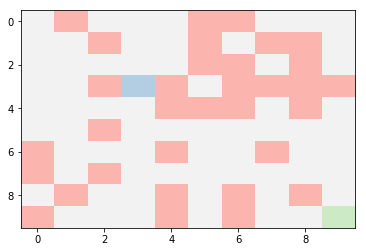

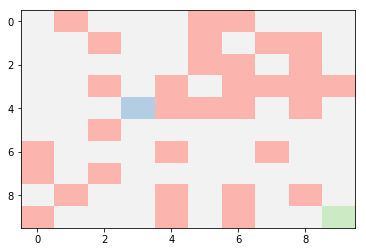

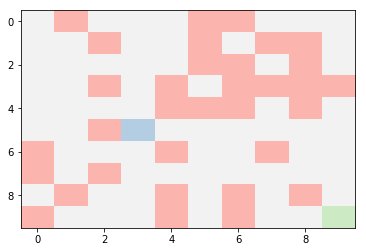

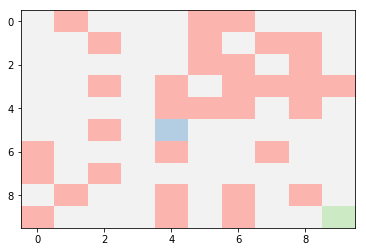

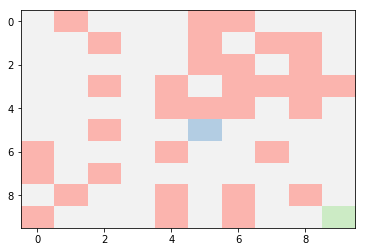

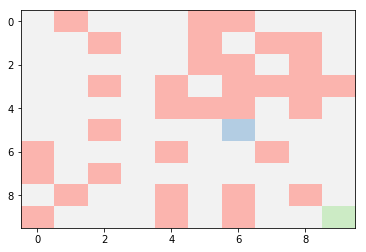

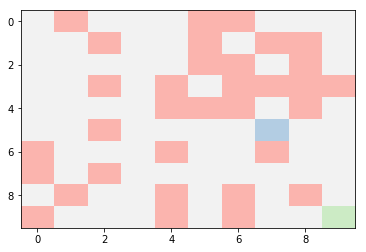

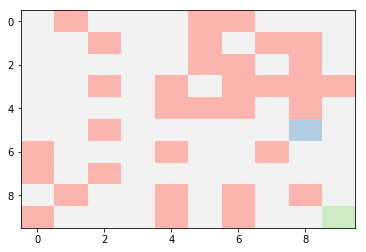

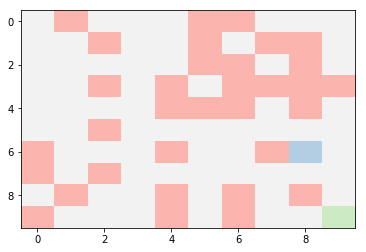

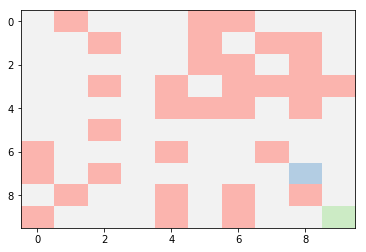

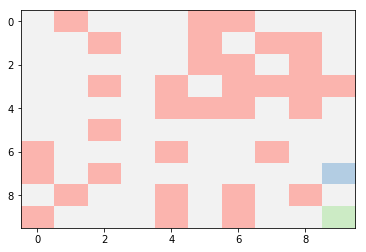

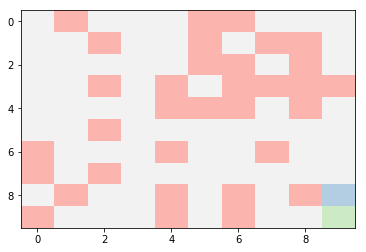

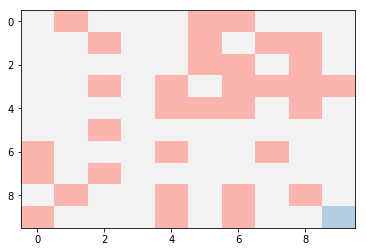

In [696]:
play_single_game(env, agent, qtable, display=True, evaluation=True)

Note that the set of states is discrete: it is a finite set that we can compute beforehand. Most of the problems in real life have a set ofstatse with infinite or exponentially large size.

Feel free to play with the notebook or add more functionalities. Some ideas:

- Play with the parameters (e.g. learning rate, discount factor)
- Reduce the probability of taking a random chance as we start winning games.